More work evaluating quality of topics and identifying potential sources of errors and possible avenues for improvement.

### Import packages

In [9]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [10]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [11]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [12]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [13]:
model_spec = {"model_directory": "saved_models/topic20_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 20,
              "description": "test model"}

In [14]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [15]:
saved = Saved_state(model_spec)

In [16]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims
dictionary = saved.dictionary
model_runtime = saved.model_runtime

print "Restored", model_spec["description"], "originally run at", model_runtime

Restored test model originally run at 2017-12-09 22:12:32.176898


## Looking at words that appear in multiple topics

Inspecting our topics, we have a number of words that appear in multiple topics, like 'think'.  These may not be helping with the distinctiveness of each topic, and may be getting learned because of our short document lengths.

In [17]:
def get_topic_counts(model_spec, topn):
    '''Retrieves saved model from a model spec.  Returns a dict containing
       how many of the topics each word that is in the top n of at least one topic
       shows up in the top n for a topic.
       
       Helps identify words that may be uninformative for topic modelling.'''
    
    topic_words = dict()
    topic_count = defaultdict(int)
    
    saved = Saved_state(model_spec)

    ldamodel = saved.ldamodel

    for n in range(model_spec["num_topics"]):
        
        topic_words[n] = ldamodel.show_topic(n, topn = topn)

    for topic in topic_words:
        for w in topic_words[topic]:
            topic_count[w[0]] += 1
            
    return topic_count
#     return topic_words

In [18]:
word_counts = get_topic_counts(model_spec, 50)

In [19]:
multi_counts = [(w, word_counts[w]) for w in word_counts if word_counts[w] > 1]
sorted_multi_counts = sorted(multi_counts, key = lambda w: w[1], reverse = True)
sorted_multi_counts

[(u'see', 12),
 (u'look', 11),
 (u'go', 10),
 (u'new', 10),
 (u'think', 10),
 (u'come', 10),
 (u'one', 9),
 (u'us', 9),
 (u'well', 8),
 (u'want', 7),
 (u'realli', 7),
 (u'year', 7),
 (u'take', 7),
 (u'busi', 7),
 (u'get', 7),
 (u'product', 7),
 (u'actual', 7),
 (u'good', 6),
 (u'term', 6),
 (u'continu', 6),
 (u'expect', 6),
 (u'first', 6),
 (u'point', 6),
 (u'like', 6),
 (u'rate', 5),
 (u'two', 5),
 (u'move', 5),
 (u'side', 5),
 (u'NUM', 5),
 (u'lot', 5),
 (u'plan', 5),
 (u'impact', 5),
 (u'make', 5),
 (u'also', 5),
 (u'know', 5),
 (u'back', 5),
 (u'growth', 5),
 (u'question', 5),
 (u'way', 5),
 (u'time', 5),
 (u'consum', 4),
 (u'higher', 4),
 (u'work', 4),
 (u'basi', 4),
 (u'talk', 4),
 (u'increas', 4),
 (u'said', 4),
 (u'last', 4),
 (u'improv', 4),
 (u'much', 4),
 (u'right', 4),
 (u'market', 4),
 (u'opportun', 4),
 (u'start', 4),
 (u'level', 3),
 (u'cost', 3),
 (u'gener', 3),
 (u'great', 3),
 (u'chang', 3),
 (u'use', 3),
 (u'obvious', 3),
 (u'give', 3),
 (u'end', 3),
 (u'grow', 3),
 

## Evaluating topic distributions

LDA should be concentrating topic probabilities for each document into a relatively small number of topics.  Want to inspect to see how true that is.

Note that Gensim cuts off topics below 0.01 in the list returned.  We can check what that's doing further below.

In [20]:
def get_topic_dists(model_spec):
    '''Perform inference to calc topic distibutions for a model
       on our dataset.
       
       Return a dictionary of topic distributions, keyed by (file_id, qnum, q/a)
       tuples.'''

    topic_dists = defaultdict(dict)
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
        
    ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
    dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
    
    
    print "starting"
    start_time = time.time()
    i = 0
    report_every = 10000
    
    min_sequence_length = model_spec["min_sequence_length"]

    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                q_bow = dictionary.doc2bow(question)
                a_bow = dictionary.doc2bow(answer)
                topic_dists[file_id+"_"+q_number+"_"+"q"] = ldamodel[q_bow]
                topic_dists[file_id+"_"+q_number+"_"+"a"] = ldamodel[a_bow]             
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in", time.time() - start_time
    print "Finished in", time.time() - start_time
    
        
    return topic_dists

In [21]:
topic_dists = get_topic_dists(model_spec)

starting
Processed  10000 pairs in 11.4970560074
Processed  20000 pairs in 23.952231884
Processed  30000 pairs in 36.4980299473
Processed  40000 pairs in 48.8482010365
Processed  50000 pairs in 61.8617248535
Processed  60000 pairs in 75.0514810085
Processed  70000 pairs in 86.817814827
Processed  80000 pairs in 99.7907190323
Finished in 105.364871979


In [22]:
def calc_topic_scores(topic_dists):
    '''Build a dictionary of stats about the topic probs in
       a dict of a distribution of topics.
       
       Return a dict of scores for each item in the original dict'''

    topic_scores = defaultdict(dict)

    for t in topic_dists.keys():

        assigned_topics = sorted(topic_dists[t], key = lambda x: x[1], reverse = True)
        num_topics = len(assigned_topics)
        max_prob = assigned_topics[0][1]
        min_prob = assigned_topics[-1][1]
        sum_prob = max_prob
        cum_prob = dict()
        cum_prob[0] = max_prob
        for i in range(1, num_topics):
            cum_prob[i] = cum_prob[i-1] + assigned_topics[i][1]
            sum_prob += assigned_topics[i][1]

        topic_scores[t]["max_prob"] = max_prob
        topic_scores[t]["min_prob"] = min_prob
        topic_scores[t]["sum_prob"] = sum_prob
        topic_scores[t]["cum_prob"] = cum_prob
        topic_scores[t]["num_topics"] = num_topics
        
    return topic_scores


topic_scores = calc_topic_scores(topic_dists)

## Visualize the topic scores

#### Number of topics

Mean Number of topics a doc is assigned to 6.51885856745
SD Number of topics a doc is assigned to 2.13088214664


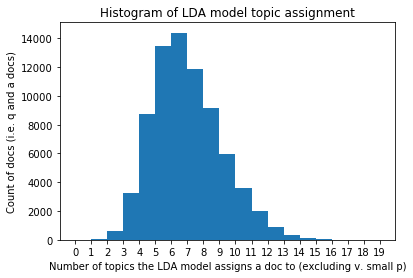

In [23]:
def histo_num_topics(topic_scores):
    n_topics = [topic_scores[t]["num_topics"] for t in topic_scores]
    print "Mean Number of topics a doc is assigned to", np.mean(n_topics)
    print "SD Number of topics a doc is assigned to", np.std(n_topics)

    plt.hist(n_topics, bins = range(20))
    plt.xlabel("Number of topics the LDA model assigns a doc to (excluding v. small p)")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model topic assignment")
    plt.xticks(range(20))
    plt.show()
    
histo_num_topics(topic_scores)

#### Probability of highest topic

Mean of highest probability for a topic that a doc is assigned to 0.4002490142
SD of highest probability 0.12213257903


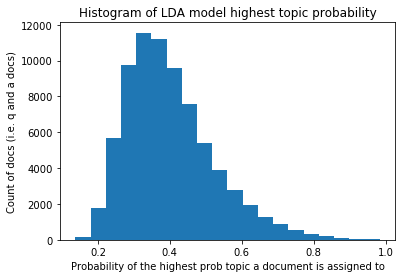

In [24]:
def histo_max_prob(topic_scores):
    max_probs = [topic_scores[t]["max_prob"] for t in topic_scores]
    print "Mean of highest probability for a topic that a doc is assigned to", np.mean(max_probs)
    print "SD of highest probability", np.std(max_probs)

    plt.hist(max_probs, bins = 20)
    plt.xlabel("Probability of the highest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model highest topic probability")
    plt.show()
    
histo_max_prob(topic_scores)

#### Buildup of probability across topics

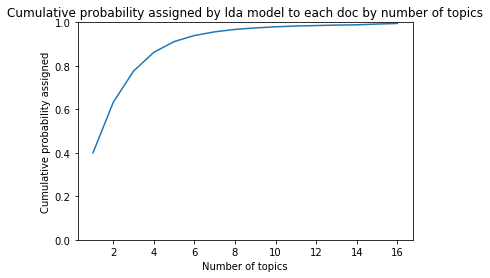

In [25]:
def chart_cum_prob(topic_scores):
    all_cums = defaultdict(int)
    total = defaultdict(int)
    for t in topic_scores.keys():
        for n in topic_scores[t]["cum_prob"]:
            all_cums[n] += topic_scores[t]["cum_prob"][n]
            total[n] += 1

    all_cums = [all_cums[n]/total[n] for n in sorted(all_cums.keys())]
    all_cums

    plt.plot(range(1, len(all_cums) +1), all_cums)

    plt.xlabel("Number of topics")
    plt.ylabel("Cumulative probability assigned")
    plt.title("Cumulative probability assigned by lda model to each doc by number of topics")
    plt.ylim([0, 1])
    plt.show()
    
chart_cum_prob(topic_scores)


#### Probability of lowest topic

Mean of lowest probability for a topic that a doc is assigned to 0.0449204144809
SD of highest probability 0.0467176149419


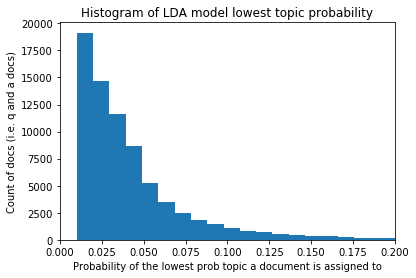

In [26]:
def histo_min_prob(topic_scores):
    min_probs = [topic_scores[t]["min_prob"] for t in topic_scores]
    print "Mean of lowest probability for a topic that a doc is assigned to", np.mean(min_probs)
    print "SD of highest probability", np.std(min_probs)

    plt.hist(min_probs, bins = 100)
    plt.xlabel("Probability of the lowest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model lowest topic probability")
    plt.xlim([0,0.2])
    plt.show()
    
histo_min_prob(topic_scores)

#### Probability of all topics scored

Recall that gensim cuts off any below 0.1, so this gives us another check that everything is working as we expect, and also an ability to see if many topics have a lot of mass across low probaility topics.

Mean of highest probability for a topic that a doc is assigned to 0.983762585193
SD of highest probability 0.00847262065545


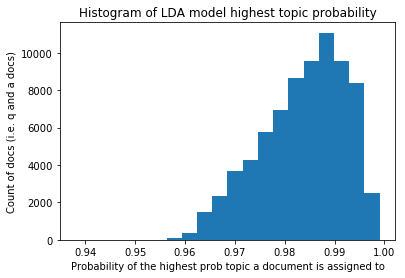

In [27]:
def histo_sum_probs(topic_scores):
    sum_probs = [topic_scores[t]["sum_prob"] for t in topic_scores]
    print "Mean of highest probability for a topic that a doc is assigned to", np.mean(sum_probs)
    print "SD of highest probability", np.std(sum_probs)

    plt.hist(sum_probs, bins = 20)
    plt.xlabel("Probability of the highest prob topic a document is assigned to")
    plt.ylabel("Count of docs (i.e. q and a docs)")
    plt.title("Histogram of LDA model highest topic probability")
    plt.show()
    
histo_sum_probs(topic_scores)

## Comparing topic distributions across the models we have

In [28]:
# First wave of models
# model_dir_list = ["topic10_minlength10_base", "topic10_minlength20_base", "topic10_minlength40_base",
#                   "topic20_minlength10_base", "topic20_minlength20_base", "topic20_minlength40_base",
#                   "topic40_minlength10_base", "topic40_minlength20_base", "topic40_minlength40_base",
#                   "topic100_minlength20_base", "topic20_minlength20_base_20passes"]

# Second wave of models
# model_dir_list = ["top10_len10_prebase_ps20_it100", "top10_len20_prebase_ps20_it100",
#                   "top10_len40_prebase_ps20_it100", "top20_len10_prebase_ps20_it100",
#                   "top20_len20_prebase_ps20_it100", "top20_len40_prebase_ps20_it100",
#                   "top40_len10_prebase_ps20_it100", "top40_len20_prebase_ps20_it100",
#                   "top40_len40_prebase_ps20_it100"]

# Third wave of models
model_dir_list = ["top20_len20_prebase_df5", "top20_len20_prebase_df10",
                  "top20_len20_prebase_df20"]

spec_list = dict()
topic_scores = dict()
        
for model_dir in model_dir_list:
    
    print "working on", model_dir
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
        spec_list[model_dir] = json.loads(f.read())
        
    topic_dists = get_topic_dists(spec_list[model_dir])
    
    # Write out to file to save having to run everything to access them again
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_dists.txt", "w") as f:
        f.write(json.dumps(topic_dists))
    
    topic_scores[model_dir] = calc_topic_scores(topic_dists)
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_scores.txt", "w") as f:
        f.write(json.dumps(topic_scores))


working on top20_len20_prebase_df5
starting
Processed  10000 pairs in 4.19491386414
Processed  20000 pairs in 8.53269600868
Processed  30000 pairs in 13.2425940037
Processed  40000 pairs in 17.6631729603
Processed  50000 pairs in 22.1418938637
Processed  60000 pairs in 26.9100699425
Processed  70000 pairs in 31.4026210308
Processed  80000 pairs in 36.7497019768
Finished in 38.9564950466
working on top20_len20_prebase_df10
starting
Processed  10000 pairs in 8.69648480415
Processed  20000 pairs in 17.5836389065
Processed  30000 pairs in 26.2250089645
Processed  40000 pairs in 34.9946568012
Processed  50000 pairs in 44.271987915
Processed  60000 pairs in 52.5745358467
Processed  70000 pairs in 60.6382498741
Processed  80000 pairs in 69.3779418468
Finished in 73.1676769257
working on top20_len20_prebase_df20
starting
Processed  10000 pairs in 12.4054658413
Processed  20000 pairs in 27.1262168884
Processed  30000 pairs in 39.2621998787
Processed  40000 pairs in 51.6859388351
Processed  5000

In [75]:
# Reload from saved distributions
# The topic dist is the slow step, so just recalculating topic scores here

def load_topic_dists(model_dir_list):
    '''return topic dists for all the models in the list'''
    
    topic_dist_dict = dict()
    for model_dir in model_dir_list:
        with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_dists.txt") as f:
            topic_dist_dict[model_dir] = json.loads(f.read())
            
    return topic_dist_dict

spec_list = dict()
topic_scores = dict()

topic_dist_dict = load_topic_dists(model_dir_list)

for model_dir in topic_dist_dict:
    topic_scores[model_dir] = calc_topic_scores(topic_dist_dict[model_dir])
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/model_spec.txt") as f:
        spec_list[model_dir] = json.loads(f.read())

top20_len20_prebase_df10
Topics 20, Min Length 20, base plus df 0.10 threshold

Mean Number of topics a doc is assigned to 6.68057088487
SD Number of topics a doc is assigned to 2.1575087956


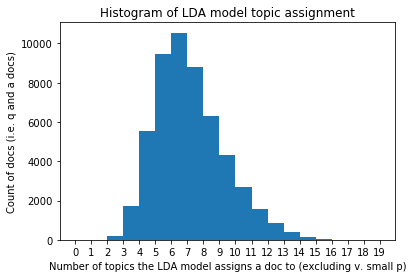

top20_len20_prebase_df5
Topics 20, Min Length 20, base plus df 0.05 threshold

Mean Number of topics a doc is assigned to 6.53625319693
SD Number of topics a doc is assigned to 2.13927534575


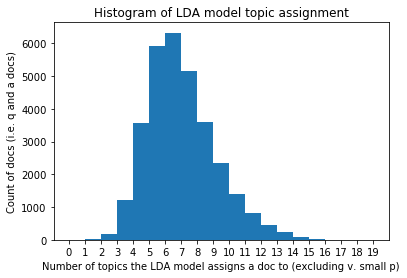

top20_len20_prebase_df20
Topics 20, Min Length 20, base plus df 0.20 threshold

Mean Number of topics a doc is assigned to 6.60107773646
SD Number of topics a doc is assigned to 2.16181271908


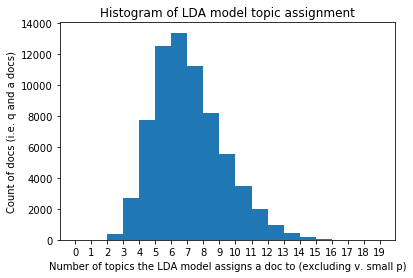

In [29]:
for m in topic_scores:
    print m
    print spec_list[m]["description"]
    print
    histo_num_topics(topic_scores[m])


Topics 20, Min Length 20, base plus df 0.10 threshold

Mean of highest probability for a topic that a doc is assigned to 0.370209266994
SD of highest probability 0.114662330942


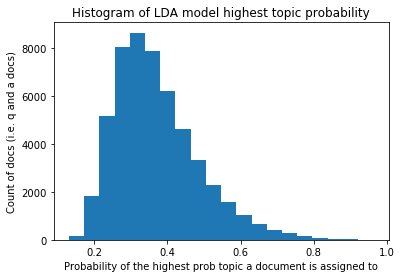


Topics 20, Min Length 20, base plus df 0.05 threshold

Mean of highest probability for a topic that a doc is assigned to 0.389898075367
SD of highest probability 0.127190226242


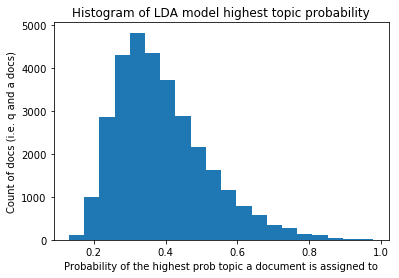


Topics 20, Min Length 20, base plus df 0.20 threshold

Mean of highest probability for a topic that a doc is assigned to 0.389024601945
SD of highest probability 0.116333766742


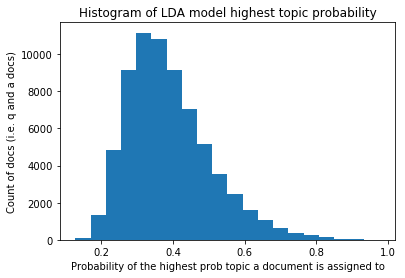

In [30]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_max_prob(topic_scores[m])


Topics 20, Min Length 20, base plus df 0.10 threshold



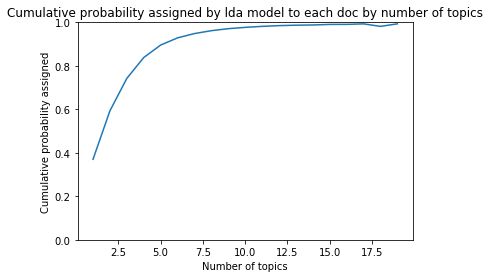


Topics 20, Min Length 20, base plus df 0.05 threshold



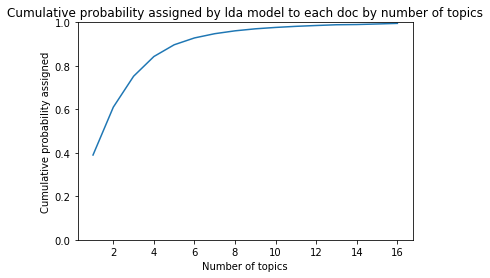


Topics 20, Min Length 20, base plus df 0.20 threshold



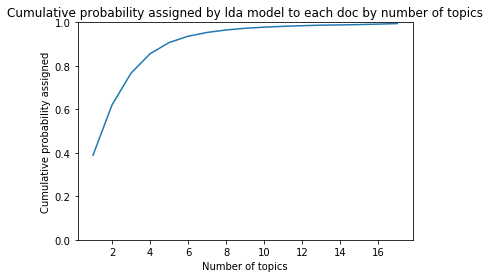

In [31]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    chart_cum_prob(topic_scores[m])


Topics 20, Min Length 20, base plus df 0.10 threshold

Mean of lowest probability for a topic that a doc is assigned to 0.0487495323376
SD of highest probability 0.0403757408521


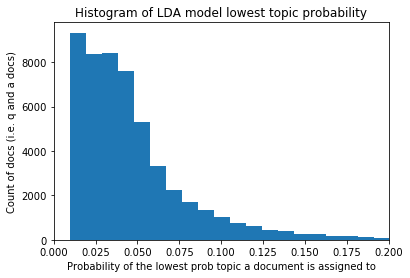


Topics 20, Min Length 20, base plus df 0.05 threshold

Mean of lowest probability for a topic that a doc is assigned to 0.0509164514246
SD of highest probability 0.0427976652338


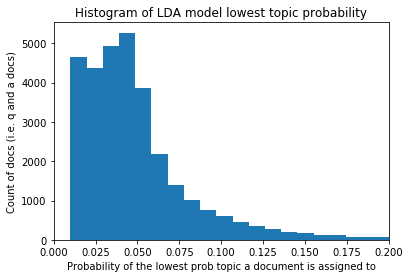


Topics 20, Min Length 20, base plus df 0.20 threshold

Mean of lowest probability for a topic that a doc is assigned to 0.0459171094856
SD of highest probability 0.0436896704888


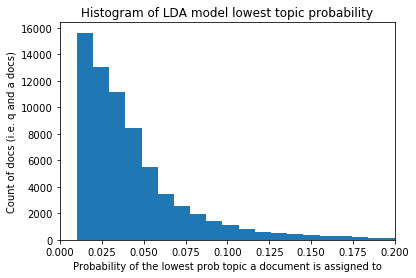

In [32]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_min_prob(topic_scores[m])


Topics 20, Min Length 20, base plus df 0.10 threshold

Mean of highest probability for a topic that a doc is assigned to 0.982242514682
SD of highest probability 0.00902766289248


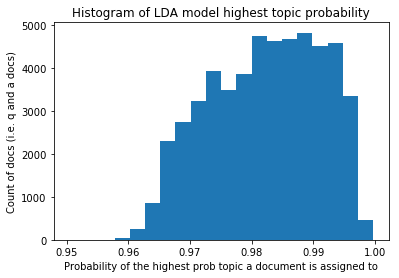


Topics 20, Min Length 20, base plus df 0.05 threshold

Mean of highest probability for a topic that a doc is assigned to 0.980724945651
SD of highest probability 0.009396132826


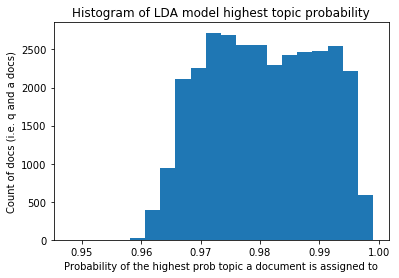


Topics 20, Min Length 20, base plus df 0.20 threshold

Mean of highest probability for a topic that a doc is assigned to 0.983371186816
SD of highest probability 0.00863192605531


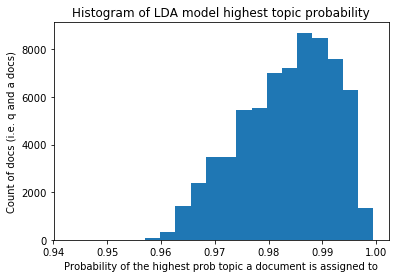

In [33]:
for m in topic_scores:
    print
    print spec_list[m]["description"]
    print
    histo_sum_probs(topic_scores[m])


Topics 20, Min Length 20, base preprocessing, passes20, iterations100

Mean Number of topics a doc is assigned to 6.79388269354
SD Number of topics a doc is assigned to 2.12951318384


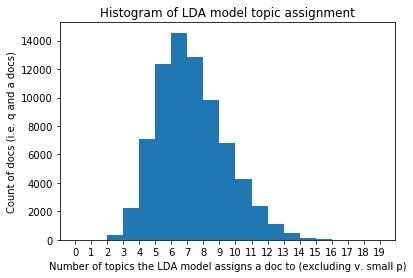

Mean of highest probability for a topic that a doc is assigned to 0.388517112076
SD of highest probability 0.115804340217


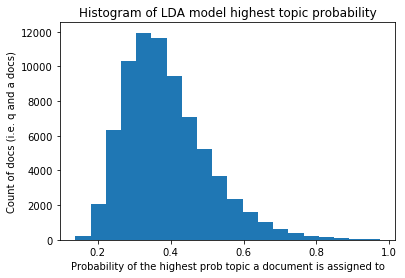

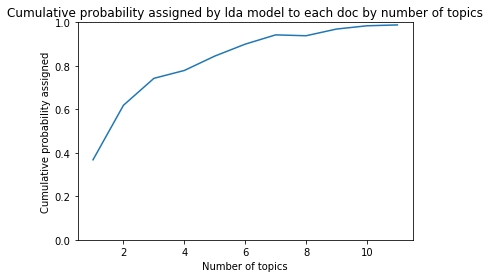

Mean of lowest probability for a topic that a doc is assigned to 0.0419039769935
SD of highest probability 0.0399554679952


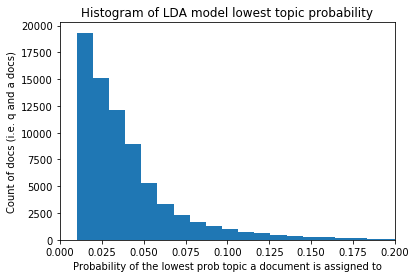

Mean of highest probability for a topic that a doc is assigned to 0.984048001688
SD of highest probability 0.008389162732


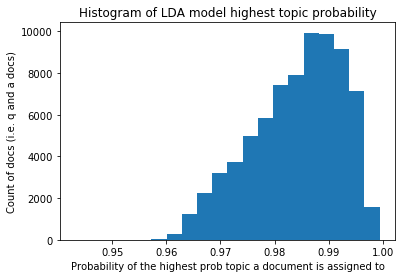

In [169]:
# for m in topic_scores:
#     print
#     print spec_list[m]["description"]
#     print
#     histo_num_topics(topic_scores[m])
#     histo_max_prob(topic_scores[m])
#     chart_cum_prob(topic_scores[m])
#     histo_min_prob(topic_scores[m])
#     histo_sum_probs(topic_scores[m])

In [ ]:
# for m in topic_scores:
#     print
#     print spec_list[m]["description"]
#     print
#     histo_num_topics(topic_scores[m])
#     histo_max_prob(topic_scores[m])
#     chart_cum_prob(topic_scores[m])
#     histo_min_prob(topic_scores[m])
#     histo_sum_probs(topic_scores[m])

In [35]:
for model_dir in model_dir_list:
    model_spec = spec_list[model_dir]
    word_counts = get_topic_counts(model_spec, 50)
    multi_counts = [(w, word_counts[w]) for w in word_counts if word_counts[w] > 1]
    sorted_multi_counts = sorted(multi_counts, key = lambda w: w[1], reverse = True)
    print model_spec["description"]
    print
    print "Top 20 words that show up in multiple topics (word, n topics)"
    for w in sorted_multi_counts[:20]:
        print w

Topics 20, Min Length 20, base plus df 0.05 threshold

Top 20 words that show up in multiple topics (word, n topics)
(u'let', 7)
(u'strong', 6)
(u'grow', 6)
(u'spend', 6)
(u'develop', 6)
(u'higher', 6)
(u'lower', 6)
(u'consum', 5)
(u'program', 5)
(u'use', 5)
(u'peopl', 5)
(u'day', 5)
(u'rel', 5)
(u'provid', 5)
(u'across', 5)
(u'benefit', 5)
(u'manag', 5)
(u'u', 5)
(u'potenti', 5)
(u'certainli', 4)
Topics 20, Min Length 20, base plus df 0.10 threshold

Top 20 words that show up in multiple topics (word, n topics)
(u'obvious', 8)
(u'product', 8)
(u'increas', 8)
(u'actual', 8)
(u'start', 8)
(u'new', 7)
(u'still', 7)
(u'number', 7)
(u'around', 7)
(u'forward', 7)
(u'chang', 6)
(u'two', 6)
(u'next', 6)
(u'grow', 6)
(u'said', 6)
(u'impact', 6)
(u'revenu', 6)
(u'level', 5)
(u'gener', 5)
(u'move', 5)
Topics 20, Min Length 20, base plus df 0.20 threshold

Top 20 words that show up in multiple topics (word, n topics)
(u'get', 9)
(u'come', 9)
(u'well', 9)
(u'rate', 8)
(u'new', 8)
(u'continu', 8)
(

Still got plenty of words that show up in multiple topics